# XGBoost

In [2]:
from random import shuffle
from random import randint
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from operator import itemgetter
import time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import gc

## Load previously prepared data

In [3]:
df = pd.read_csv('data/laptop_train.csv')

In [4]:
df.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),resolution,screentype,touchscreen,cpu(GHz),memory_1_storage_gb,memory_1_type,memory_2_storage_gb,memory_2_type,log_price
0,4,239,3,15.6,49,6,53,5,2.30,0,2,0,2.4,1000.0,1,0.0,3,6.129050
1,10,291,1,15.6,58,8,75,5,2.50,3,0,0,2.5,256.0,3,0.0,3,6.720220
2,4,576,4,13.3,81,8,61,5,1.20,3,2,0,1.8,256.0,3,0.0,3,7.364547
3,2,602,4,13.3,38,8,46,5,1.20,3,0,0,0.9,512.0,3,0.0,3,6.591674
4,4,239,3,15.6,47,4,24,2,2.25,0,2,0,2.0,1000.0,1,0.0,3,6.143370


In [5]:
df.columns

Index(['company', 'product', 'typename', 'inches', 'cpu', 'ram(GB)', 'gpu',
       'opsys', 'weight(kg)', 'resolution', 'screentype', 'touchscreen',
       'cpu(GHz)', 'memory_1_storage_gb', 'memory_1_type',
       'memory_2_storage_gb', 'memory_2_type', 'log_price'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132 entries, 0 to 1131
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1132 non-null   int64  
 1   product              1132 non-null   int64  
 2   typename             1132 non-null   int64  
 3   inches               1132 non-null   float64
 4   cpu                  1132 non-null   int64  
 5   ram(GB)              1132 non-null   int64  
 6   gpu                  1132 non-null   int64  
 7   opsys                1132 non-null   int64  
 8   weight(kg)           1132 non-null   float64
 9   resolution           1132 non-null   int64  
 10  screentype           1132 non-null   int64  
 11  touchscreen          1132 non-null   int64  
 12  cpu(GHz)             1132 non-null   float64
 13  memory_1_storage_gb  1132 non-null   float64
 14  memory_1_type        1132 non-null   int64  
 15  memory_2_storage_gb  1132 non-null   f

In [7]:
target = "log_price"
numericFeatures = ["inches", "ram(GB)", "weight(kg)", "cpu(GHz)", "memory_1_storage_gb", "memory_2_storage_gb"]
catFeatures = ["company", "product", "typename", "cpu", "gpu", "opsys", "resolution", "screentype", "touchscreen", "memory_1_type", "memory_2_type"]

In [8]:
df

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),resolution,screentype,touchscreen,cpu(GHz),memory_1_storage_gb,memory_1_type,memory_2_storage_gb,memory_2_type,log_price
0,4,239,3,15.6,49,6,53,5,2.30,0,2,0,2.4,1000.0,1,0.0,3,6.129050
1,10,291,1,15.6,58,8,75,5,2.50,3,0,0,2.5,256.0,3,0.0,3,6.720220
2,4,576,4,13.3,81,8,61,5,1.20,3,2,0,1.8,256.0,3,0.0,3,7.364547
3,2,602,4,13.3,38,8,46,5,1.20,3,0,0,0.9,512.0,3,0.0,3,6.591674
4,4,239,3,15.6,47,4,24,2,2.25,0,2,0,2.0,1000.0,1,0.0,3,6.143370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,7,111,3,14.0,52,4,47,5,1.54,3,2,0,2.3,500.0,1,0.0,3,6.907755
1128,0,77,3,15.6,57,8,86,5,2.40,3,2,0,2.5,256.0,3,1000.0,0,6.683361
1129,7,27,3,15.6,73,8,53,5,2.04,0,2,0,2.7,2000.0,1,0.0,3,6.444131
1130,7,324,3,15.6,10,6,29,5,2.04,3,2,0,2.9,1000.0,2,0.0,3,6.309900


In [9]:
X=df.drop('log_price', axis = 1).values
y=df['log_price'].values

## Hyperparameter tuning

In [10]:
import xgboost as xgb
from sklearn.metrics import r2_score


In [11]:
features = df.columns.tolist()
features.remove(target)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.3)
model = xgb.XGBRegressor()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
print("R2 score:", r2_score(y_test,y_predict))


[23:54:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 score: 0.9084235447408725


In [13]:
def run_xgb(train, validate, features, target, # must have parameters
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hypermarapeters
            colsample_bylevel=1, lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hypermarapeters
            rate_drop = 0.2, skip_drop=0.5, # hypermarapeters
            num_boost_round = 1000, early_stopping_rounds = 50, # hypermarapeters
            debug=True, eval_metric= ["rmse"], objective = "reg:linear", # config
            seed=2023, booster = "gbtree", tree_method="exact", grow_policy="depthwise",
           verbosity=1, silent=False): # config
   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective',
          'seed', 'booster', 'tree_method', 'grow_policy', 'verbosity', 'silent']
    
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    params["lambda"]=lambdaX
    
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    train_history = dict()

    # Training algorithm
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    score = gbm.best_score

    # Transform the history of training into pandas DataFrame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Feature importance
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

In [14]:
test_size = 0.2
X_train, X_valid = train_test_split(df, test_size=test_size, random_state=2023)

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['rmse'], objective reg:linear, seed 2023, booster gbtree, tree_method exact, grow_policy depthwise, verbosity 1, silent False, 
Length train: 905
Length valid: 227
[0]	train-rmse:6.16803	valid-rmse:6.18264
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1]	train-rmse:5.98461	valid-rmse:5.99851
[2]	train-rmse:5.80666	valid-rmse:5.81993
[3]	train-rmse:5.63327	valid-rmse:5.64586
[4]	train-rmse:5.46583	valid-rmse:5.47846
[5]	train-rmse:5.30379	valid-rmse:5.31672
[6]	train-rmse:5.14612	valid-rmse:5.15909
[7]	train-rmse:4.9932	valid-rmse:5.00554
[8]	train-rmse:4.84475	valid-rmse:4.85648
[9]	train-rmse:4.70069	valid-rmse:4.71249
[10]	train-rmse:4.56103	valid-rmse:4.57229
[11]	tra

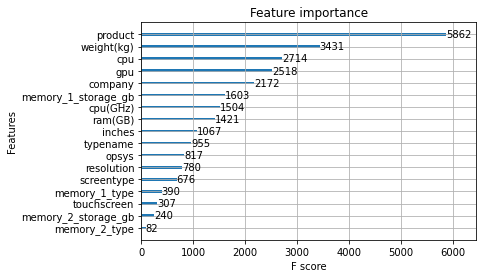

In [15]:
score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features, target, early_stopping_rounds=50)

In [16]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Wraper
def CVTestXGB(nFolds = 5, randomState=2020, features=features, debug=False, *args, **kwargs):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    testResults = []
    trainResults = []
    
    predictions = []
    
    indices = []
    
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        # Estimator:
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        predictions.append(testPred.tolist().copy())
        
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Info of each fold
        trainScore = np.round(r2_score(df[target].iloc[train], trainPred),4)*100
        testScore = np.round(r2_score(df[target].iloc[test], testPred),4)*100
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
          print("Train R2: {:.2f} %".format(trainScore),
                "Test R2: {:.2f} %".format(testScore))
        
    return trainResults, testResults, predictions, indices, pd.concat(hists, axis=1)

In [17]:
trainResults, testResults, predictions, indices, hists = CVTestXGB(
    max_depth=8, subsample=0.7, colsample_bytree=0.7, lambdaX=4, gamma=0.1, debug=False, verbosity=0)
np.mean(trainResults), np.mean(testResults)

(96.79400000000001, 92.614)

In [18]:
import random
results=[]
paramList = []
for x in range(200):
    params = (random.randint(3, 9), random.uniform(0.1, 0.9), random.uniform(0.1, 0.9), random.uniform(0, 10), random.uniform(0, 10), random.uniform(0.01, 0.25), random.uniform(0, 60))
    trainResults, testResults, predictions, indices, hists = CVTestXGB(
        max_depth=params[0],
        subsample = params[1],
        colsample_bytree = params[2],
        lambdaX=params[3],
        gamma=params[4],
        eta=params[5],
        min_child_weight=params[6])
    print(np.mean(testResults), params)
    results.append(np.mean(testResults))
    paramList.append(params)


48.57 (3, 0.10700345210701574, 0.3544164204332727, 8.208882060307602, 1.3328923217225397, 0.21610804432291503, 49.113510940858)
71.898 (7, 0.2617786757989342, 0.3773371973768881, 3.1064431022441266, 3.476743016876227, 0.23460154975763128, 53.30999601851467)
50.004 (7, 0.10814703332679515, 0.8963520123550649, 5.534343985669676, 3.8457565925733483, 0.0643501386118121, 47.41228797607866)
75.262 (5, 0.6773490837417145, 0.7171930776975832, 9.528624009934877, 6.194314886052429, 0.24927686485661277, 33.56814653335609)
83.622 (5, 0.708382873101958, 0.2281249194685173, 9.961967078424541, 1.4868103434098934, 0.024136521382060926, 51.38454420588026)
81.322 (7, 0.7754377852296582, 0.7217234326613198, 9.93584849754514, 3.1253335279450747, 0.21109213593332493, 0.26583164674752524)
80.892 (4, 0.48670241983763574, 0.7570383119578804, 5.914473414071316, 2.4847778115899546, 0.08029089287434144, 0.34660743801464333)
83.86 (3, 0.6769934613375693, 0.10483845667382585, 1.8416554386268191, 1.7133746457167054

In [19]:
maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)

(92.578, (9, 0.4923455000631808, 0.6993051668482431, 0.7857921958527714, 0.059657083660437094, 0.10918301235569373, 22.189028104694653))
(92.508, (7, 0.5303295862068578, 0.8828242338023856, 1.4038508557398888, 0.09275993743106947, 0.10040224308862601, 9.799787364572467))
(92.428, (6, 0.4372171619543025, 0.22822503657079019, 7.1597567972529585, 0.021601964460069567, 0.24792582066559474, 13.25038829841193))
(91.25399999999999, (5, 0.8309961182811757, 0.4788849903828657, 4.865057678242058, 0.12490330152816198, 0.10130079832235439, 40.70158594760241))
(89.596, (6, 0.3940151970381749, 0.6774085795097771, 8.965943972301867, 0.26643940551001943, 0.21382082846801992, 12.138005132419824))
(88.66599999999998, (6, 0.7311191693000726, 0.3566539887769731, 2.8343956573329354, 0.4746096128636512, 0.06476308954373841, 38.466111304559256))
(88.626, (6, 0.8996674311322868, 0.13551454932030182, 5.738098779330897, 0.5100692175159749, 0.08403305898158268, 31.621714221688386))
(88.082, (7, 0.608743976907382

In [20]:
trainResults, testResults, predictions, indices, hists = CVTestXGB( 
    max_depth=9, subsample=0.4923455000631808, colsample_bytree=0.6993051668482431, lambdaX= 0.7857921958527714, gamma= 0.059657083660437094, eta = 0.10918301235569373, min_child_weight = 22.189028104694653, debug=False, verbosity=0)
np.mean(trainResults), np.mean(testResults)

(96.704, 92.578)

Results after hyperparameter tuning are better than without it\
R2: 92.614 %
vs.
R2: 92.578 %

## Save the model

Let's save the model. I will later compare the performance of different models on the testing dataset

In [21]:
import pickle

In [22]:
model = xgb.XGBRegressor(max_depth=9, 
                         subsample=0.4923455000631808, 
                         colsample_bytree=0.6993051668482431, 
                         lambdaX= 0.7857921958527714, 
                         gamma= 0.059657083660437094, 
                         eta = 0.10918301235569373,
                         min_child_weight = 22.189028104694653)
model.fit(df[features], df[target])

[00:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.6993051668482431, eta=0.10918301235569373,
             gamma=0.059657083660437094, lambdaX=0.7857921958527714,
             max_depth=9, min_child_weight=22.189028104694653,
             subsample=0.4923455000631808)

In [25]:
pickle.dump(model, open('models/xgboost.sav', 'wb'))